In [1]:
import os
from root_gnn import utils_test
from root_gnn import dataset
from root_gnn import prepare
from root_gnn import utils_train
from root_gnn.model import GeneralClassifier

import tensorflow as tf
from graph_nets import utils_tf
from graph_nets import utils_np
import os
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

/global/homes/x/xju/.conda/envs/gnnana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/global/homes/x/xju/.conda/envs/gnnana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/global/homes/x/xju/.conda/envs/gnnana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/global/homes/x/xju/.conda/envs/gn


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


Welcome to JupyROOT 6.18/00


In [2]:
input_dir = '/global/homes/x/xju/project/xju/examples/gnn_examples/H4l_ggF_vs_VBF/h4l_minitree_prod_v20'
signal_file = os.path.join(input_dir, 'ggf.root')
bkg_file = os.path.join(input_dir, 'vbf.root')
tree_name = 'tree_incl_all'
n_graphs = 500
output_dir = '../trained_results/ggf_vs_vbf/'
last_iteration = 4304

In [3]:
f_signal = dataset.dataset(signal_file, tree_name)
f_bkg = dataset.dataset(bkg_file, tree_name)

In [4]:
def prepare_graphs(n_graphs, is_training=True):
    all_graphs = []
    def get_graphs(input_data, index):
        for iph in range(n_graphs):
            nx_graph = input_data.generate_nxgraph(is_training=is_training)
            nx_graph.graph['solution'] = np.array([index])
            input_g, target_g = prepare.graph_to_input_target(nx_graph)
            all_graphs.append((input_g, target_g))

    get_graphs(f_signal, 1)
    get_graphs(f_bkg, 0)
    all_graphs = shuffle(all_graphs)

    input_graphs = [x[0] for x in all_graphs]
    target_graphs = [x[1] for x in all_graphs]
    return input_graphs, target_graphs

In [5]:
tf.reset_default_graph()
input_graphs, target_graphs = prepare_graphs(n_graphs, is_training=False)
input_ph  = utils_tf.placeholders_from_networkxs(input_graphs, force_dynamic_num_graphs=True)
target_ph = utils_tf.placeholders_from_networkxs(target_graphs, force_dynamic_num_graphs=True)

model = GeneralClassifier()
num_processing_steps_tr = 3
output_ops_tr = model(input_ph, num_processing_steps_tr)




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
loss_ops_tr = utils_train.create_loss_ops(target_ph, output_ops_tr)
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
ckpt_name = 'checkpoint_{:05d}.ckpt'

In [8]:
sess = tf.Session()
saver = tf.train.Saver()
print("loading checkpoint:", os.path.join(output_dir, ckpt_name.format(last_iteration)))
saver.restore(sess, os.path.join(output_dir, ckpt_name.format(last_iteration)))

loading checkpoint: ../trained_results/ggf_vs_vbf/checkpoint_04304.ckpt
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../trained_results/ggf_vs_vbf/checkpoint_04304.ckpt


2019-10-04 17:40:36.350941: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2019-10-04 17:40:36.356518: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2019-10-04 17:40:36.356539: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cori19): /proc/driver/nvidia/version does not exist
2019-10-04 17:40:36.356923: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-10-04 17:40:36.367410: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300130000 Hz
2019-10-04 17:40:36.371756: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55555ed5cf90 executing computations on platform Host. Devices:
2019-10-04 17:40:36.371770: I tensorflow/compiler/xla/se

In [9]:
n_batches = 10
all_pred = []
all_target = []
for _ in range(n_batches):
    input_graphs, target_graphs = prepare_graphs(n_graphs, is_training=False)
    input_graphs_ntuple = utils_np.networkxs_to_graphs_tuple(input_graphs)
    target_graphs_ntuple = utils_np.networkxs_to_graphs_tuple(target_graphs)

    feed_dict = {
        input_ph: input_graphs_ntuple,
        target_ph: target_graphs_ntuple
    }

    test_values = sess.run({
        "target": target_ph,
        "outputs": output_ops_tr
    }, feed_dict=feed_dict)
    test_pred, test_target = utils_train.eval_output(test_values['target'], test_values['outputs'][-1])
    all_pred.append(test_pred)
    all_target.append(test_target)

In [10]:
test_pred = np.concatenate(all_pred, axis=0)
test_target = np.concatenate(all_target, axis=0)

Accuracy:            0.7315
Precision (purity):  0.6702
Recall (efficiency): 0.9116


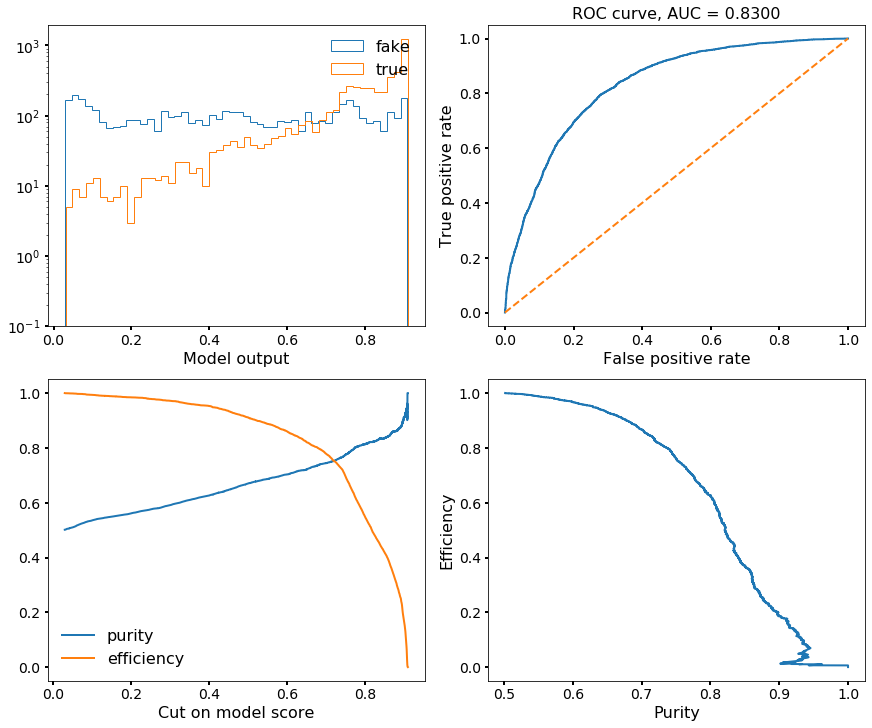

In [11]:
utils_test.plot_metrics(test_pred, test_target, odd_th=0.5)